# Combined PINN Training and Estimating Paramters (Inverse Problem)

Starting forward problem training with real lambda and mu
Forward Epoch 0, Loss: 8315.508789
Forward Epoch 100, Loss: 427.472137
Forward Epoch 200, Loss: 32.589241
Forward Epoch 300, Loss: 14.044405
Forward Epoch 400, Loss: 8.402592
Forward Epoch 500, Loss: 5.635145
Forward Epoch 600, Loss: 3.891035
Forward Epoch 700, Loss: 2.850995
Forward Epoch 800, Loss: 2.160311
Forward Epoch 900, Loss: 1.738838
Forward Epoch 1000, Loss: 1.444879
Forward Epoch 1100, Loss: 1.259560
Forward Epoch 1200, Loss: 1.112703
Forward Epoch 1300, Loss: 9.071963
Forward Epoch 1400, Loss: 0.912297

Starting inverse problem to estimate lambda and mu
Inverse Epoch 0, Loss: 2079.945801, lamb: 0.9990, mu: 0.4990
Inverse Epoch 100, Loss: 232.326721, lamb: 0.9314, mu: 0.4333
Inverse Epoch 200, Loss: 8.863537, lamb: 0.9245, mu: 0.4248
Inverse Epoch 300, Loss: 3.048697, lamb: 0.9240, mu: 0.4237
Inverse Epoch 400, Loss: 1.884100, lamb: 0.9238, mu: 0.4230
Inverse Epoch 500, Loss: 1.137267, lamb: 0.9237, mu: 0.4226
Inverse

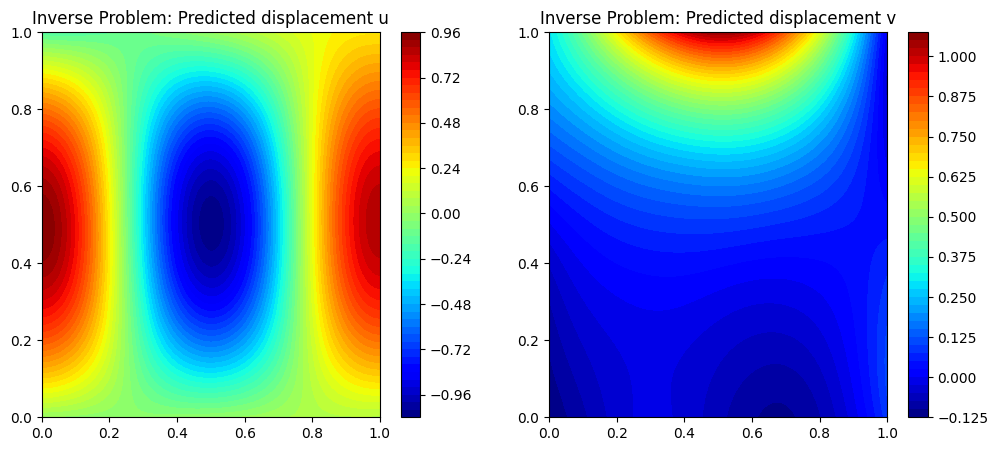

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# -- Forward problem: known parameters (real values)
lamb_real = 2.0
mu_real = 1.0
Q = 4.0

# Neural Network definition
class SimplePINN(tf.keras.Model):
    def __init__(self, layer_sizes):
        super(SimplePINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(size, activation='tanh') for size in layer_sizes[:-1]]
        self.output_layer = tf.keras.layers.Dense(layer_sizes[-1])
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

def stiffness_matrix(lamb, mu, case="plane_strain"):
    lamb = tf.convert_to_tensor(lamb, dtype=tf.float32)
    mu = tf.convert_to_tensor(mu, dtype=tf.float32)
    if case == "plane_stress":
        raise ValueError("Invalid case: Choose 'plane_stress' or 'plane_strain'")
    elif case == "plane_strain":
        C11 = lamb + 2*mu
        C12 = lamb
        C66 = mu
    else:
        raise ValueError("Invalid case: Choose 'plane_stress' or 'plane_strain'")
    C = tf.stack([
        [C11, C12, 0],
        [C12, C11, 0],
        [0, 0, C66]
    ])
    return C

def body_force_fn(points, lamb, mu, Q):
    x = points[:,0:1]
    y = points[:,1:2]
    f0 = lamb * (4 * np.pi ** 2 * tf.cos(2 * np.pi * x) * tf.sin(np.pi * y) - np.pi * tf.cos(np.pi * x) * Q * y**3) + \
         mu * (9 * np.pi ** 2 * tf.cos(2 * np.pi * x) * tf.sin(np.pi * y) - np.pi * tf.cos(np.pi * x) * Q * y**3)
    f1 = lamb * (-3 * tf.sin(np.pi * x) * Q * y**2 + 2 * (np.pi**2) * tf.sin(2 * np.pi * x) * tf.cos(np.pi * y)) + \
         mu * (-6 * tf.sin(np.pi * x) * Q * y**2 + 2 * (np.pi**2) * tf.sin(2 * np.pi * x) * tf.cos(np.pi * y) + ((np.pi**2) * tf.sin(np.pi * x) * Q * y**4) / 4)
    return tf.stack(tf.stack([tf.reshape(f0, [-1]), tf.reshape(f1, [-1])], axis=1))

def compute_pde_residual(model, points, StiffMat, lamb, mu, Q, body_force_fn):
    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(points)
        with tf.GradientTape(persistent=True) as inner_tape:
            inner_tape.watch(points)
            predicted_uv = model(points)
            predicted_u = predicted_uv[:, 0:1]
            predicted_v = predicted_uv[:, 1:2]
        grad_u = inner_tape.gradient(predicted_u, points)
        grad_v = inner_tape.gradient(predicted_v, points)
        Sxx = StiffMat[0, 0] * grad_u[:, 0:1] + StiffMat[0, 1] * grad_v[:, 1:2]
        Syy = StiffMat[1, 0] * grad_u[:, 0:1] + StiffMat[1, 1] * grad_v[:, 1:2]
        Sxy = StiffMat[2, 2] * (grad_u[:, 1:2] + grad_v[:, 0:1])
    Sxx_x = outer_tape.gradient(Sxx, points)[:, 0]
    Syy_y = outer_tape.gradient(Syy, points)[:, 1]
    grad_Sxy = outer_tape.gradient(Sxy, points)
    Sxy_x = grad_Sxy[:, 0]
    Sxy_y = grad_Sxy[:, 1]
    del inner_tape, outer_tape
    body_force = body_force_fn(points, lamb, mu, Q)
    residue = tf.stack([Sxx_x + Sxy_y + body_force[:, 0], Sxy_x + Syy_y + body_force[:, 1]], axis=1)
    return residue

def compute_total_loss(model, points, left, right, bottom, top, StiffMat, lamb, mu, Q, body_force_fn, data_points=None, data_u=None, data_v=None):
    # PDE residual loss
    residue = compute_pde_residual(model, points, StiffMat, lamb, mu, Q, body_force_fn)
    pde_loss = tf.reduce_mean(tf.square(residue[:, 0])) + tf.reduce_mean(tf.square(residue[:, 1]))

    # Boundary losses (same as forward)
    with tf.GradientTape(persistent=True) as inner_tape:
        inner_tape.watch(left)
        predicted_uv = model(left)
        predicted_u = predicted_uv[:, 0:1]
        predicted_v = predicted_uv[:, 1:2]
    grad_u = inner_tape.gradient(predicted_u, left)
    grad_v = inner_tape.gradient(predicted_v, left)
    del inner_tape
    Sxx = StiffMat[0, 0] * grad_u[:, 0:1] + StiffMat[0, 1] * grad_v[:, 1:2]
    left_boundary_loss = tf.reduce_mean(tf.square(predicted_v)) + tf.reduce_mean(tf.square(Sxx))

    with tf.GradientTape(persistent=True) as inner_tape:
        inner_tape.watch(right)
        predicted_uv = model(right)
        predicted_u = predicted_uv[:, 0:1]
        predicted_v = predicted_uv[:, 1:2]
    grad_u = inner_tape.gradient(predicted_u, right)
    grad_v = inner_tape.gradient(predicted_v, right)
    del inner_tape
    Sxx = StiffMat[0, 0] * grad_u[:, 0:1] + StiffMat[0, 1] * grad_v[:, 1:2]
    right_boundary_loss = tf.reduce_mean(tf.square(predicted_v)) + tf.reduce_mean(tf.square(Sxx))

    bottom_boundary_loss = tf.reduce_mean(tf.square(model(bottom)[:, 0:1])) + tf.reduce_mean(tf.square(model(bottom)[:, 1:2]))

    with tf.GradientTape(persistent=True) as inner_tape:
        inner_tape.watch(top)
        predicted_uv = model(top)
        predicted_u = predicted_uv[:, 0:1]
        predicted_v = predicted_uv[:, 1:2]
    grad_u = inner_tape.gradient(predicted_u, top)
    grad_v = inner_tape.gradient(predicted_v, top)
    del inner_tape
    Syy = StiffMat[1, 0] * grad_u[:, 0:1] + StiffMat[1, 1] * grad_v[:, 1:2]
    top_boundary_loss = tf.reduce_mean(tf.square(predicted_u)) + tf.reduce_mean(tf.square(Syy - (lamb + 2*mu) * Q * tf.sin(np.pi * top[:, 0:1])))

    total_loss = pde_loss + left_boundary_loss + right_boundary_loss + bottom_boundary_loss + top_boundary_loss

    # If data is provided, add data mismatch loss
    if data_points is not None and data_u is not None and data_v is not None:
        pred_data = model(data_points)
        data_loss = tf.reduce_mean(tf.square(pred_data[:, 0:1] - data_u)) + tf.reduce_mean(tf.square(pred_data[:, 1:2] - data_v))
        total_loss += data_loss

    return total_loss

# Setup domain points and boundaries
num_collocation_points = 50
x_points, y_points = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
points = tf.stack([tf.reshape(x_points, [-1]), tf.reshape(y_points, [-1])], axis=1)

x_left, y_left = tf.meshgrid(tf.linspace(0.0, 0.0, 1), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
left = tf.stack([tf.reshape(x_left, [-1]), tf.reshape(y_left, [-1])], axis=1)

x_right, y_right = tf.meshgrid(tf.linspace(1.0, 1.0, 1), tf.linspace(0.0, 1.0, num_collocation_points), indexing="ij")
right = tf.stack([tf.reshape(x_right, [-1]), tf.reshape(y_right, [-1])], axis=1)

x_top, y_top = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(1.0, 1.0, 1), indexing="ij")
top = tf.stack([tf.reshape(x_top, [-1]), tf.reshape(y_top, [-1])], axis=1)

x_bottom, y_bottom = tf.meshgrid(tf.linspace(0.0, 1.0, num_collocation_points), tf.linspace(0.0, 0.0, 1), indexing="ij")
bottom = tf.stack([tf.reshape(x_bottom, [-1]), tf.reshape(y_bottom, [-1])], axis=1)

case2D = "plane_strain"

# -------- FORWARD PROBLEM TRAINING --------
print("Starting forward problem training with real lambda and mu")

model_forward = SimplePINN([50, 50, 50, 50, 50, 2])
optimizer_forward = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs_forward = 1500
tolerance = 1e-6
previous_loss = float('inf')

for epoch in range(num_epochs_forward):
    with tf.GradientTape() as tape:
        StiffMat = stiffness_matrix(lamb_real, mu_real, case2D)
        loss = compute_total_loss(model_forward, points, left, right, bottom, top, StiffMat, lamb_real, mu_real, Q, body_force_fn)
    gradients = tape.gradient(loss, model_forward.trainable_variables)
    optimizer_forward.apply_gradients(zip(gradients, model_forward.trainable_variables))

    if epoch % 100 == 0:
        print(f"Forward Epoch {epoch}, Loss: {loss.numpy():.6f}")
        if abs(previous_loss - loss.numpy()) < tolerance:
            print(f"Forward problem converged at epoch {epoch}")
            break
        previous_loss = loss.numpy()

# Generate synthetic data from forward-trained model (simulate measurements)
num_data_points = 100
x_data, y_data = tf.meshgrid(tf.linspace(0.0, 1.0, int(np.sqrt(num_data_points))), tf.linspace(0.0, 1.0, int(np.sqrt(num_data_points))), indexing="ij")
data_points = tf.stack([tf.reshape(x_data, [-1]), tf.reshape(y_data, [-1])], axis=1)
pred_uv_data = model_forward(data_points)
data_u = pred_uv_data[:, 0:1]
data_v = pred_uv_data[:, 1:2]

# -------- INVERSE PROBLEM: Estimate lambda and mu --------
print("\nStarting inverse problem to estimate lambda and mu")

# Initial guess for lambda and mu (different from real)
lamb_inv = tf.Variable(1.0, dtype=tf.float32, trainable=True)
mu_inv = tf.Variable(0.5, dtype=tf.float32, trainable=True)

model_inverse = SimplePINN([50, 50, 50, 50, 50, 2])
optimizer_inverse = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs_inverse = 1500
previous_loss = float('inf')

for epoch in range(num_epochs_inverse):
    with tf.GradientTape() as tape:
        StiffMat = stiffness_matrix(lamb_inv, mu_inv, case2D)
        loss = compute_total_loss(model_inverse, points, left, right, bottom, top, StiffMat, lamb_inv, mu_inv, Q, body_force_fn, data_points, data_u, data_v)
    gradients = tape.gradient(loss, model_inverse.trainable_variables + [lamb_inv, mu_inv])
    optimizer_inverse.apply_gradients(zip(gradients, model_inverse.trainable_variables + [lamb_inv, mu_inv]))

    if epoch % 100 == 0:
        print(f"Inverse Epoch {epoch}, Loss: {loss.numpy():.6f}, lamb: {lamb_inv.numpy():.4f}, mu: {mu_inv.numpy():.4f}")
        if abs(previous_loss - loss.numpy()) < tolerance:
            print(f"Inverse problem converged at epoch {epoch}")
            break
        previous_loss = loss.numpy()

print(f"\nEstimated lambda: {lamb_inv.numpy():.6f}, Estimated mu: {mu_inv.numpy():.6f}")

# Plot predicted displacement fields from inverse problem
num_plot_points = 100
x_plot, y_plot = tf.meshgrid(tf.linspace(0.0, 1.0, num_plot_points), tf.linspace(0.0, 1.0, num_plot_points), indexing="ij")
plot_points = tf.stack([tf.reshape(x_plot, [-1]), tf.reshape(y_plot, [-1])], axis=1)
pred_uv_inv = model_inverse(plot_points)
pred_u_inv = tf.reshape(pred_uv_inv[:, 0], (num_plot_points, num_plot_points))
pred_v_inv = tf.reshape(pred_uv_inv[:, 1], (num_plot_points, num_plot_points))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(x_plot, y_plot, pred_u_inv, levels=50, cmap='jet')
plt.colorbar()
plt.title('Inverse Problem: Predicted displacement u')

plt.subplot(1, 2, 2)
plt.contourf(x_plot, y_plot, pred_v_inv, levels=50, cmap='jet')
plt.colorbar()
plt.title('Inverse Problem: Predicted displacement v')
plt.show()
